# Animal Oregon Classification 


In [91]:
#importing libraries 
import numpy as np 
import pandas as pd 
import os, time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report
import shutil
from PIL import Image, ImageOps
from sklearn.utils import class_weight
import tensorflow as tf
import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D,Dropout, Flatten
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras import mixed_precision
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import KFold
import tensorflow_hub as hub
mixed_precision.set_global_policy('mixed_float16')

## Exploratory Data Analysis

<Axes: title={'center': 'Image Distribution'}, xlabel='count', ylabel='Animal'>

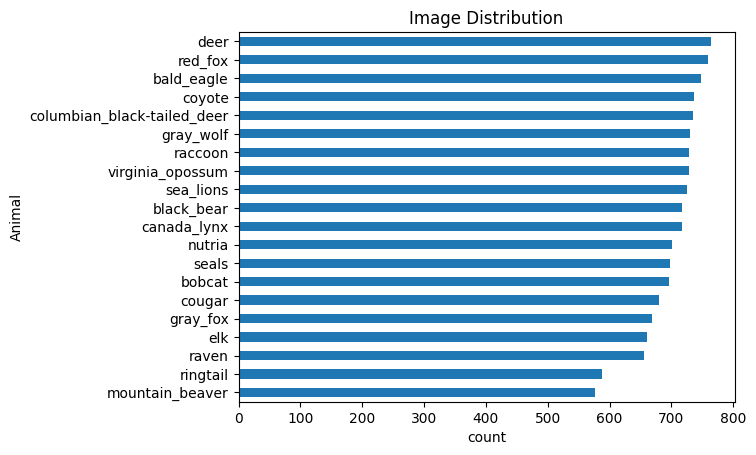

In [3]:
#importing image data
img_root_path = '/kaggle/input/oregon-wildlife/oregon_wildlife/oregon_wildlife'
animal_img = os.listdir(img_root_path)

animal_dir_dict = {animal : len(os.listdir(os.path.join(img_root_path,f'{animal}/'))) for animal in animal_img}

animal_series = pd.Series( list(animal_dir_dict.values()) , index = list(animal_dir_dict.keys()))
animal_series.sort_values().plot(kind = 'barh',title = 'Image Distribution', xlabel = 'count', ylabel = 'Animal')

There're 20 classes in this image data, but their data distribution aren't balanced yet. There're some classes with abundant total of images, such as deer and redfox. Also, each of them have more than 700 image data. Otherwise, other classes, such as ring tail, mountain beaver have images fewer than 600. 

In [4]:
print('total data :',animal_series.sum(axis = 0))

total data : 14013


## Data Preprocessing

In [5]:
#make train, validation and test folder
os.makedirs('train_val',exist_ok =True)
os.makedirs('test',exist_ok =True)

In [6]:
#preprocess image
def resize_image(input_path, output_path):
    try:
        with Image.open(input_path) as img:
            img = img.resize((224, 224))

            if img.mode == 'RGBA':
                img = img.convert('RGB')
            img.save(output_path,'PNG')
    except Exception as e:
        print(f"Error processing {input_path}: {e}")
        
def process_image(args):
    input_path, output_path = args
    resize_image(input_path, output_path)

In [7]:
#split image data (90% for training and validation ; 10% for testing) and set their path and class into list 
OUTPUT_DIR = '/kaggle/working/'
files_list = []
cls_list = []

for cls_name in animal_img:
    #get class root path
    class_dir = os.path.join(img_root_path, f'{cls_name}/')
    img_files = os.listdir(class_dir)

    #get all image file paths
    img_file_paths = [os.path.join(class_dir, img) for img in img_files]
    
    #make directories for each class
    os.makedirs(f'{OUTPUT_DIR}/train_val/{cls_name}/', exist_ok=True)
    os.makedirs(f'{OUTPUT_DIR}/test/{cls_name}/', exist_ok=True)

    tasks = []
    
    for i in range(len(img_file_paths)):
        input_path = img_file_paths[i]
        output_path = os.path.join(f'{OUTPUT_DIR}/test/{cls_name}', img_files[i]) if i >= int(len(img_file_paths) * 0.9) else os.path.join(f'{OUTPUT_DIR}/train_val/{cls_name}', img_files[i])
        tasks.append((input_path, output_path))
        if i < int(len(img_file_paths) * 0.9):
            files_list.append(output_path)
            cls_list.append(cls_name)

    with ThreadPoolExecutor(max_workers=4) as executor:
        executor.map(process_image, tasks)

Error processing /kaggle/input/oregon-wildlife/oregon_wildlife/oregon_wildlife/coyote/f135f34a055bb829f0.jpg: cannot write mode CMYK as PNG


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Error processing /kaggle/input/oregon-wildlife/oregon_wildlife/oregon_wildlife/columbian_black-tailed_deer/50426f859f0e900f29.jpg: cannot write mode CMYK as PNG
Error processing /kaggle/input/oregon-wildlife/oregon_wildlife/oregon_wildlife/columbian_black-tailed_deer/f4e4b5e708fef62447.jpg: cannot write mode CMYK as PNG
Error processing /kaggle/input/oregon-wildlife/oregon_wildlife/oregon_wildlife/columbian_black-tailed_deer/4d4b9ea126039a0c3c.jpg: cannot write mode CMYK as PNG
Error processing /kaggle/input/oregon-wildlife/oregon_wildlife/oregon_wildlife/columbian_black-tailed_deer/a123861a99e20a949f.jpg: cannot write mode CMYK as PNG
Error processing /kaggle/input/oregon-wildlife/oregon_wildlife/oregon_wildlife/columbian_black-tailed_deer/671994f61f6bd28436.jpg: cannot write mode CMYK as PNG
Error processing /kaggle/input/oregon-wildlife/oregon_wildlife/oregon_wildlife/columbian_black-tailed_deer/f55ebc84ef263d903b.jpg: cannot write mode CMYK as PNG
Error processing /kaggle/input/ore

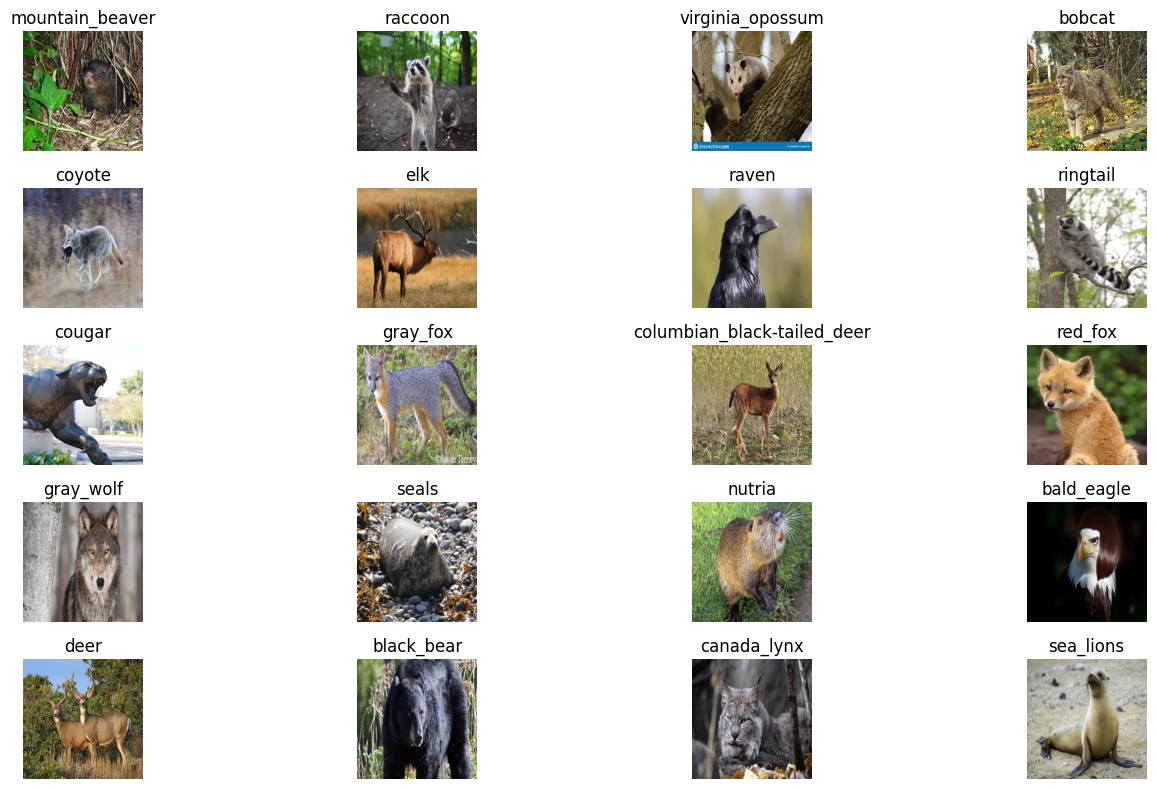

In [9]:
#display preprocessing result 
fig, axes = plt.subplots(5,4, figsize = (15,8))

for i in range(20):
    cls_name = animal_img[i]
    class_dir = f'/kaggle/working/train_val/{cls_name}/'
    img_files = os.listdir(class_dir)[1]
    img_file_path = os.path.join(class_dir,img_files)
    img = mpimg.imread(img_file_path)
    axes[i//4, i%4].imshow(img)
    axes[i//4, i%4].set_title(cls_name)
    axes[i//4, i%4].axis('off')
        
fig.tight_layout()

In [13]:
#prepare train and test generator
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_generator = ImageDataGenerator(rescale=1./255)

In [95]:
test_generator = ImageDataGenerator(rescale=1./255)

## Modeling (Using inception V3)

The modelling process began with Inception V3. Inception-v3 is a convolutional neural network model that introduces various enhancements, such as Label Smoothing, Factorized 7x7 convolutions, and the integration of an auxiliary classifier to help distribute label information to the lower layers of the network. Additionally, it employs batch normalization in the sidehead layers to improve performance.

In [10]:
#import base model 
model_base = keras.applications.InceptionV3(
    input_shape = (224,224,3),
    weights='imagenet',
    pooling = 'max',
    include_top= False,
)

model_base.trainable = False

model_base.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [11]:
#compile base model with adamW optimizer
model = Sequential([
    model_base, 
    Dense(1024, activation = 'relu'),
    Dropout(0.5),
    Dense(512, activation = 'relu'),
    Dropout(0.3),
    Dense(20, activation = 'softmax')
])

model.compile(optimizer = 'adamW', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [94]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │        10,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,702,498 (113.31 MB)

 Trainable params: 2,633,236 (10.04 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 5,266,478 (20.09 MB)

In [12]:
#setting callback functions for model training
callback_list = [ModelCheckpoint('/kaggle/working/best_weight.keras', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)
                 , ReduceLROnPlateau('val_loss', factor = 0.1, patience = 4, mode = 'min') ]

## Model Training

The model have trained by 4 segmented Kfold data, each of them are trained with 25 epochs. 

In [15]:
#training model with Kfold, each train and validation data splits into 4 data;
k_fold = KFold(n_splits = 4, shuffle = True, random_state = 23)
histories = {} 

for fold, (train_indices, val_indices) in enumerate(k_fold.split(files_list)):
    print(f"Fold {fold + 1}")
    
    train_paths = [files_list[i] for i in train_indices]
    train_labels = [cls_list[i] for i in train_indices]
    
    val_paths = [files_list[i] for i in val_indices]
    val_labels = [cls_list[i] for i in val_indices]
    
    train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
    test_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})
    
    train_dataset = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size = (224,224),
        batch_size=32,
    )

    valid_dataset = valid_generator.flow_from_dataframe(
        dataframe = test_df,
        x_col='filename',
        y_col='class',
        target_size = (224,224),
        batch_size=32,
    )
    
    history = model.fit(train_dataset, validation_data = valid_dataset, callbacks = callback_list, epochs = 25)
    
    histories[f'fold_{fold+1}'] = history.history

Fold 1
Found 9414 validated image filenames belonging to 20 classes.
Found 3133 validated image filenames belonging to 20 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 40 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 19 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/295 ━━━━━━━━━━━━━━━━━━━━ 2:40:49 33s/step - accuracy: 0.1250 - loss: 8.4193

I0000 00:00:1723965574.234067     168 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 18/295 ━━━━━━━━━━━━━━━━━━━━ 1:41 365ms/step - accuracy: 0.0612 - loss: 7.3752

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 58/295 ━━━━━━━━━━━━━━━━━━━━ 2:31 641ms/step - accuracy: 0.0969 - loss: 7.3351

W0000 00:00:1723965610.775765     169 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.3437 - loss: 4.0948
Epoch 1: val_accuracy improved from -inf to 0.71242, saving model to /kaggle/working/best_weight.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 188s 526ms/step - accuracy: 0.3447 - loss: 4.0828 - val_accuracy: 0.7124 - val_loss: 0.7843 - learning_rate: 0.0010
Epoch 2/25
294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.5989 - loss: 1.2039
Epoch 2: val_accuracy improved from 0.71242 to 0.72359, saving model to /kaggle/working/best_weight.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 122s 405ms/step - accuracy: 0.5989 - loss: 1.2041 - val_accuracy: 0.7236 - val_loss: 0.7732 - learning_rate: 0.0010
Epoch 3/25
294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.6021 - loss: 1.2013
Epoch 3: val_accuracy did not improve from 0.72359
295/295 ━━━━━━━━━━━━━━━━━━━━ 122s 403ms/step - accuracy: 0.6021 - loss: 1.2013 - val_accuracy: 0.7175 - val_loss: 0.7379 - learning_rate: 0.0010
Epoch 4/25
294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 49 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 10 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


293/294 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7710 - loss: 0.6798
Epoch 1: val_accuracy improved from 0.83307 to 0.84755, saving model to /kaggle/working/best_weight.keras


W0000 00:00:1723968791.789814     169 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


294/294 ━━━━━━━━━━━━━━━━━━━━ 131s 438ms/step - accuracy: 0.7710 - loss: 0.6797 - val_accuracy: 0.8475 - val_loss: 0.4725 - learning_rate: 1.0000e-04
Epoch 2/25
293/294 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7766 - loss: 0.6765
Epoch 2: val_accuracy improved from 0.84755 to 0.85423, saving model to /kaggle/working/best_weight.keras
294/294 ━━━━━━━━━━━━━━━━━━━━ 120s 400ms/step - accuracy: 0.7766 - loss: 0.6764 - val_accuracy: 0.8542 - val_loss: 0.4856 - learning_rate: 1.0000e-04
Epoch 3/25
293/294 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7673 - loss: 0.6767
Epoch 4: val_accuracy did not improve from 0.85423
294/294 ━━━━━━━━━━━━━━━━━━━━ 119s 396ms/step - accuracy: 0.7673 - loss: 0.6766 - val_accuracy: 0.8520 - val_loss: 0.4882 - learning_rate: 1.0000e-04
Epoch 5/25
293/294 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7862 - loss: 0.6504
Epoch 5: val_accuracy did not improve from 0.85423
294/294 ━━━━━━━━━━━━━━━━━━━━ 119s 397ms/step - accuracy: 0.7862 - loss: 0.6504 - 

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 44 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 15 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


122/295 ━━━━━━━━━━━━━━━━━━━━ 1:26 499ms/step - accuracy: 0.7760 - loss: 0.6495

W0000 00:00:1723971738.896778     168 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.7779 - loss: 0.6460
Epoch 1: val_accuracy improved from 0.85423 to 0.85427, saving model to /kaggle/working/best_weight.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 136s 453ms/step - accuracy: 0.7779 - loss: 0.6459 - val_accuracy: 0.8543 - val_loss: 0.4765 - learning_rate: 1.0000e-10
Epoch 2/25
294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7770 - loss: 0.6437
Epoch 2: val_accuracy did not improve from 0.85427
295/295 ━━━━━━━━━━━━━━━━━━━━ 119s 396ms/step - accuracy: 0.7771 - loss: 0.6437 - val_accuracy: 0.8543 - val_loss: 0.4765 - learning_rate: 1.0000e-10
Epoch 3/25
294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7864 - loss: 0.6314
Epoch 3: val_accuracy did not improve from 0.85427
295/295 ━━━━━━━━━━━━━━━━━━━━ 120s 397ms/step - accuracy: 0.7864 - loss: 0.6315 - val_accuracy: 0.8543 - val_loss: 0.4765 - learning_rate: 1.0000e-10
Epoch 4/25
294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7849 - loss: 0.6453
Epoc

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 44 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 15 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7845 - loss: 0.6303
Epoch 1: val_accuracy improved from 0.85427 to 0.85619, saving model to /kaggle/working/best_weight.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 120s 398ms/step - accuracy: 0.7845 - loss: 0.6303 - val_accuracy: 0.8562 - val_loss: 0.4875 - learning_rate: 1.0000e-16
Epoch 2/25
294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7874 - loss: 0.6114
Epoch 2: val_accuracy did not improve from 0.85619
295/295 ━━━━━━━━━━━━━━━━━━━━ 119s 395ms/step - accuracy: 0.7874 - loss: 0.6115 - val_accuracy: 0.8562 - val_loss: 0.4875 - learning_rate: 1.0000e-16
Epoch 3/25
294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7859 - loss: 0.6244
Epoch 3: val_accuracy did not improve from 0.85619
295/295 ━━━━━━━━━━━━━━━━━━━━ 118s 394ms/step - accuracy: 0.7859 - loss: 0.6244 - val_accuracy: 0.8562 - val_loss: 0.4875 - learning_rate: 1.0000e-16
Epoch 4/25
294/295 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7937 - loss: 0.6072
Epoc

## Model Evaluation

In [96]:
#preparing test image data
test_dataset = test_generator.flow_from_directory(
        directory = '/kaggle/working/test',
        target_size = (224,224),
        batch_size=32,
        shuffle = False
)

true_classes = test_dataset.classes
classes = test_dataset.class_indices
classes = {i:list(classes.keys())[i] for i in range(20)}


#predicting test image data
prediction = model.predict(test_dataset).argmax(axis = 1)

Found 1399 images belonging to 20 classes.
 2/44 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/44 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step


### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

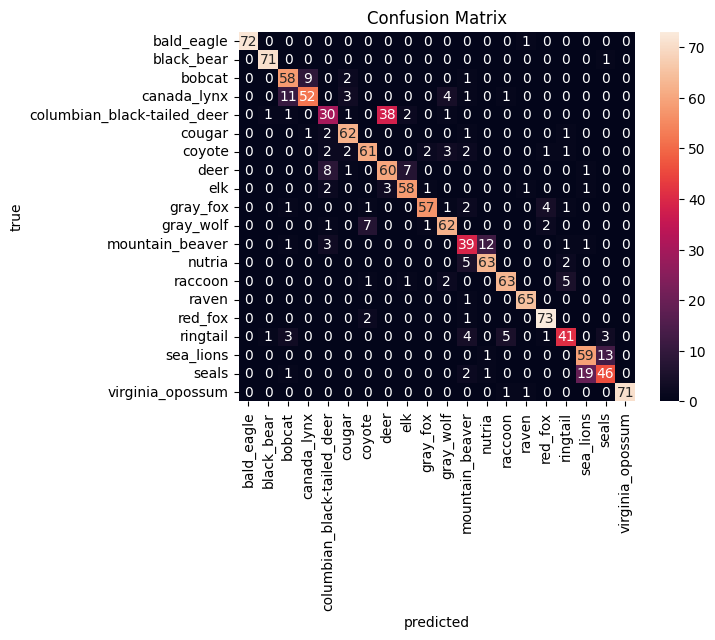

In [97]:
heatmap_data = pd.DataFrame({
    'true' : true_classes,
    'predicted' : prediction
}).replace(classes)

sns.heatmap(pd.crosstab(heatmap_data['true'],heatmap_data['predicted']), annot = True)
plt.title('Confusion Matrix')

Based on the confusion matrix, most of classes are predicted correctly. But, there're some of classes have frequent misclassified class images such as columbian black tailed deer with other types of deer. There're 30 images predicted correctly as columbian black tailed deer and some of them are misclassified as other types of deer. 

### Classification Report

In [98]:
print(classification_report(heatmap_data['true'],heatmap_data['predicted']))

                             precision    recall  f1-score   support

                 bald_eagle       1.00      0.99      0.99        73
                 black_bear       0.97      0.99      0.98        72
                     bobcat       0.76      0.83      0.79        70
                canada_lynx       0.84      0.72      0.78        72
columbian_black-tailed_deer       0.62      0.41      0.49        74
                     cougar       0.87      0.93      0.90        67
                     coyote       0.85      0.82      0.84        74
                       deer       0.59      0.78      0.67        77
                        elk       0.85      0.88      0.87        66
                   gray_fox       0.93      0.85      0.89        67
                  gray_wolf       0.85      0.85      0.85        73
            mountain_beaver       0.66      0.68      0.67        57
                     nutria       0.82      0.90      0.86        70
                    raccoon      

Around 83% of test images data are predicted correctly. Also, most of classes have high f1 score, such as bald eagle, black bear, virginia opposum, etc. Moreover, some of them have lower f1 score, such as :

1. **Columbian black tailed deer** : 
This class have f1 score around 0.49 , with recall 0.41 and precision 0.62. The low recall might caused by model that oftenly misclassified columbian black tailed deer as other animal image like deer. 

2. **Mountain beaver** : 
This class have f1 score around 0.67, with recall 0.66 and precision 0.68. The low f1 score might caused by total of train data. This class have image data fewer than 600. Also, some of these images are misclassified as nutria, which both of them may have similar body shape structure.

### Learning Curve

In [99]:
def combined_metrics(metrics):
    train = np.array([histories[f'fold_{i+1}'][f'{metrics}'] for i in range(4)]).flatten()
    val = np.array([histories[f'fold_{i+1}'][f'val_{metrics}'] for i in range(4)]).flatten()
    return train , val

train_acc, val_acc = combined_metrics(metrics = 'accuracy')
train_loss, val_loss = combined_metrics(metrics = 'loss')

Text(0, 0.5, 'Loss')

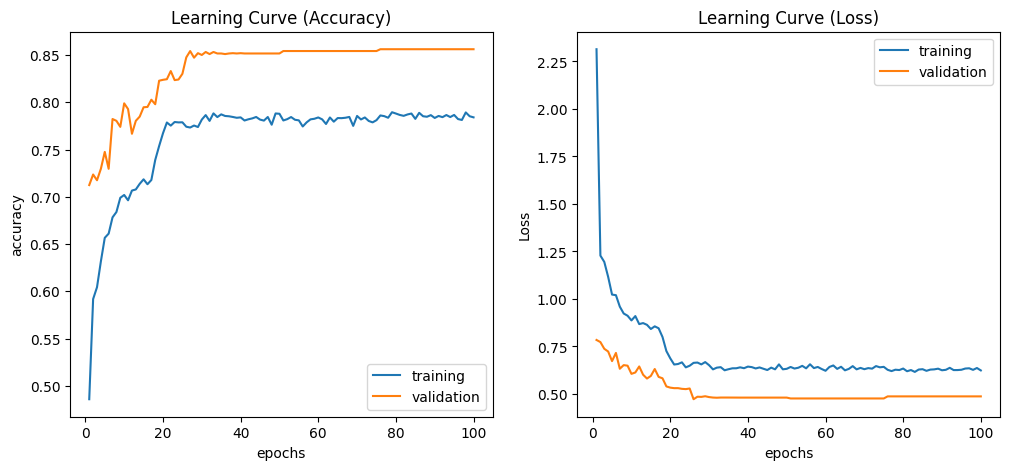

In [102]:
fig,axes = plt.subplots(1,2, figsize = (12,5))
rng = range(1,101)

axes[0].plot(rng,train_acc, label = 'training')
axes[0].plot(rng,val_acc, label = 'validation')
axes[0].legend()
axes[0].set_title('Learning Curve (Accuracy)')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')

axes[1].plot(rng,train_loss, label = 'training')
axes[1].plot(rng,val_loss, label = 'validation')
axes[1].legend()
axes[1].set_title('Learning Curve (Loss)')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('Loss')

The learning curves illustrate our image classification model's strong performance over 100 epochs. The training accuracy plateaued around 75-80%, while the validation accuracy stabilized at 85%, indicating good generalization. Notably, both training and validation losses dropped rapidly and stabilized at low values, highlighting the model's efficiency in minimizing error without overfitting.